# SITH
### Per B. Sederberg
### 2022/12/14
### License: GPL

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
from scipy.linalg import block_diag

In [2]:
from math import factorial

#####################
# functions for Big T
#####################
def _calc_D(s):
    # calc all the differences
    s0__1 = s[1:-1] - s[:-2]
    s1_0 = s[2:] - s[1:-1]
    s1__1 = s[2:] - s[:-2]

    # calc the -1, 0, and 1 diagonals
    A = -((s1_0/s1__1)/s0__1)
    B = -((s0__1/s1__1)/s1_0) + (s1_0/s1__1)/s0__1
    C = (s0__1/s1__1)/s1_0

    # create the matrix
    D = np.zeros((len(s), len(s)))
    D.flat[len(s):-2:len(s)+1] = A
    D.flat[len(s)+1:-1:len(s)+1] = B
    D.flat[len(s)+2::len(s)+1] = C
    
    return D.T

def _calc_invL(s, k):
    # calc finite differentiation matrix from s
    D = _calc_D(s)
    
    # Post inverse Laplace linear operator
    invL = (((-1.) ** k) / factorial(k)) * \
            np.dot(np.linalg.matrix_power(D, k), np.diag(s ** (k+1)))[:, k:-k]

    # return as ndarray
    return invL

In [3]:
def my_mat_power(x, n, x0=None):
    if x0 is None:
        x0 = x
    if n == 1:
        return x
    elif n == 2:
        return np.dot(x, x0)
    elif n > 2:
        return my_mat_power(np.dot(x, x0), n-1, x0=x0)
    else:
        raise ValueError("Only positive n are allowed.")
    

-347.31003799763328743 312.0555284626688035
-3071550602906.5176 3146651421216.7607
-3071550602906.518 3146651421216.7607


/tmp/ipykernel_169993/1999162792.py:26: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(np.abs(invL2)))


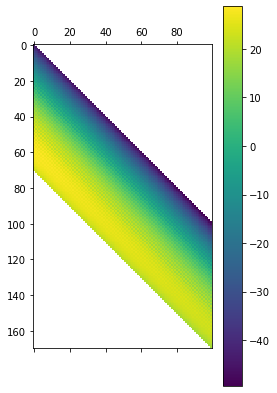

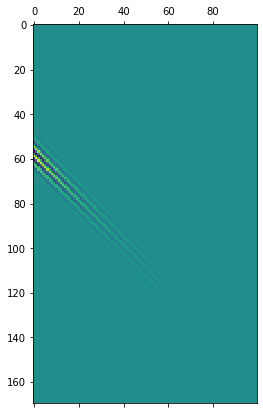

In [4]:
def _calc_invL2(s, k):
    # calc finite differentiation matrix from s
    D = np.float128(_calc_D(np.float128(s)))
    
    # Post inverse Laplace linear operator
    #invL = (((-1.) ** k) / factorial(k)) * \
    #        np.dot(np.linalg.matrix_power(D, k), np.diag(s ** (k+1)))[:, k:-k]
    invL = (((-1.) ** k) * \
            my_mat_power(D, k) * np.exp(np.log(s)*(k+1) - 
                                        np.log(np.arange(2,k+1)).sum()))[:, k:-k]
    

    # return as ndarray
    return np.float64(invL)

tau_min = 1
tau_max = 200
ntau = 100
k = 35
c = (tau_max/tau_min)**(1./(ntau-1))-1
tau_star = tau_min * (1 + c)**np.arange(-k, ntau + k)
s = k/tau_star
D = np.float128(_calc_D(s))
invL = _calc_invL(s, k)
invL2 = _calc_invL2(s, k)
plt.matshow(np.log(np.abs(invL2)))
plt.colorbar()
print(D.min(), D.max())
print(invL.min(), invL.max())
print(invL2.min(), invL2.max())

plt.matshow(invL2)

In [5]:
# SITH class
class SITH():
    def __init__(self, nf=1, tau_min=.1, tau_max=20., k=8, ntau=50, dt=.01, g=0.0):
        # save inputs
        self.k = k
        self.tau_min = tau_min
        self.tau_max = tau_max
        self.ntau = ntau
        self.dt = dt
        self.nf = nf
        self.g = g
        
        # calc tau_star and s
        self.c = (self.tau_max/self.tau_min)**(1./(ntau-1))-1
        tau_star = self.tau_min * (1 + self.c)**np.arange(-self.k, ntau + self.k)
        
        # get s from the taustar
        self.s = self.k/tau_star
        
        # calc invL linear operator based on s and k
        self.invL = _calc_invL2(self.s, k)
        #self.pL = np.linalg.pinv(self.invL)

        # pull off the edges of taustar for post invL
        self.tau_star = tau_star[k:-k]

        # some precalculated stuff for updates
        self._e_s = np.exp(-self.s)
        
        # reset ready to go
        self.reset()
        
    def reset(self):
        # clear out little t and big T
        self.t = np.zeros((self.nf, self.invL.shape[0]))
        self.T = np.dot(self.t, self.invL)
    
    def _ensure_input_size(self, vec):
        vec = np.atleast_1d(vec)
        if len(vec) != self.nf:
            # replicate across features
            vec = vec*np.ones(self.nf)
        return vec
    
    def direct_input(self, tau, amp=1.0):
        # ensure input is nf long
        tau = self._ensure_input_size(tau)
        amp = self._ensure_input_size(amp)
            
        # determine input from tau and amp
        tIN = amp[:, np.newaxis] * np.exp(tau[:, np.newaxis]*-self.s)
        
        # set t
        self.t = self.t + tIN
        
        # update T
        self.T = np.dot(self.t, self.invL) * np.power(self.tau_star, self.g)
        
    def update(self, i=None, dur=None, alpha=1.0):
        # process the duration
        if dur is None:
            # use dt
            dur = self.dt
            
        # process alpha and the duration
        e_alpha_s_dur = np.power(self._e_s, (dur*alpha))

        # process the input
        if i is None:
            # we're not adding input
            tIN = 0.0
        else:
            # make sure it's an array
            i = self._ensure_input_size(i)
            
            # set tIN across all s with proper decay
            decay = (1-e_alpha_s_dur)/(alpha*self.s)
            tIN = i[:, np.newaxis] * decay
            
        # set the new t based on decay and input
        self.t = (e_alpha_s_dur * self.t) + tIN
                 
        # update T
        self.T = np.dot(self.t, self.invL) * np.power(self.tau_star, self.g)
        

## SITH Demonstrations

c = 0.040306502726004334
c = 0.040306502726004334


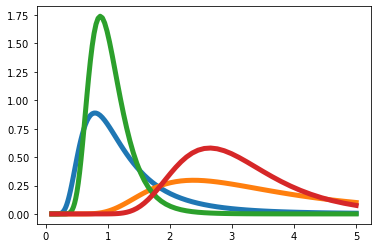

In [6]:
# Show passing in direct input to two channels
tau = [1.5, .25, 3.5]
amp = [2.0, 1.0, 3.]
tau = [1, 3]
amp = [1.0, 1.]
nfeat = len(tau)
tau_min = .1
tau_max = 5
ntau = 100


ev = SITH(nfeat, tau_min=tau_min, tau_max=tau_max, k=4, 
          ntau=ntau, dt=.001, g=0)
ev.direct_input(tau=tau, amp=amp)
print('c =', ev.c)
plt.plot(ev.tau_star, ev.T.T, lw=5);


ev = SITH(nfeat, tau_min=tau_min, tau_max=tau_max, k=12, 
          ntau=ntau, dt=.001, g=0)
ev.direct_input(tau=tau, amp=amp)
print('c =', ev.c)
plt.plot(ev.tau_star, ev.T.T, lw=5);

0.0939576468983776 [ 0.1         0.10939576  0.11967433  0.13091865  0.14321946  0.15667602
  0.17139693  0.18750099  0.20511814  0.22439056  0.24547377  0.2685379
  0.29376909  0.32137094  0.3515662   0.38459854  0.42073451  0.46026573
  0.50351122  0.55081995  0.60257369  0.6591901   0.72112605  0.78888136
  0.86300279  0.94408851  1.03279284  1.12983162  1.23598795  1.35211846
  1.47916033  1.61813876  1.77017527  1.93649677  2.11844545  2.3174896
  2.53523547  2.77344023  3.03402615  3.3190961   3.63095056  3.97210614
  4.34531588  4.75359154  5.20022781  5.68882898  6.22333797  6.80806816
  7.44773822  8.14751018  8.91303106  9.75047849 10.6666105  11.66882013
 12.76519501 13.96458269 15.27666202 16.71202124 18.28224343 20.        ]


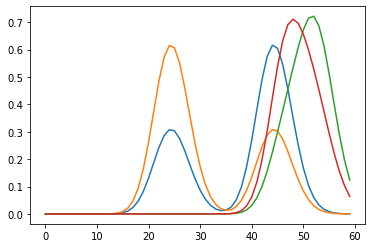

In [7]:
# quick SITH test
tau_min = .1
tau_max = 20.
k = 20
ntau = 60
dt = .01
alpha = 1.0
a = 1.5

# make SITH with 2 features
ev = SITH(2, tau_min=tau_min, tau_max=tau_max, k=k, ntau=ntau, dt=dt, g=1.0)
print(ev.c, ev.tau_star)

# give some input
ev.update([1, .5], alpha=1.0)

# decay for a bit
ev.update(alpha=1.0, dur=a*5)

# give some more input (flip level of input)
ev.update([.5, 1], alpha=1.0)

# decay for a bit
ev.update(alpha=1.0, dur=a)

# plot it
plt.plot(ev.T.T);

# decay awhile and see what happened
ev.update(dur=10., alpha=alpha)
plt.plot(ev.T.T);